In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

/home/xdsoete/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
# function used to read the action files
def get_rows_for_file(file):
    data = np.load(file)
    nb_frames, nb_points, nb_values = data.shape

    res = np.empty((nb_frames, nb_points * nb_values + 1))

    # set features
    res[:,:-1] = data.reshape((nb_frames, nb_points * nb_values))

    # set labels
    parts = file.split('-')
    action_idx = int(parts[1])
    res[:,-1] = action_idx

    return res

In [4]:
# don't forget to change the files path
files = 'actions/*.npy';
Xy = np.vstack([get_rows_for_file(filename) for filename in glob.glob(files)])
Xy.shape

# 54 features, the last column is for the label of each action

(182700, 55)

#### Check to see if the data is balanced

In [5]:
df = pd.DataFrame(Xy)

df.groupby([54]).size()

54
0.0    26100
1.0    26100
2.0    26100
3.0    26100
4.0    26100
5.0    26100
6.0    26100
dtype: int64

We can see in the output from above that the data is balanced. Every action has the same amount of data points.

#### Compute the ranges of every feature 

In [6]:
(pd.concat([df.min(), df.max()], axis=1).rename(columns={0:"min", 1:"max"})).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
min,-80.000000,0.439392,0.092422,-34.166667,22.480475,0.076566,-4.078280,25.186407,0.089867,5.534295,33.236077,0.084752,-80.000000,-24.248334,0.049430,-80.000000,19.612559,0.076566,-80.000000,5.632224,0.056809,-80.000000,-23.455584,0.045501,-80.000000,71.250000,0.067789,-1.175470,92.083333,0.068875,11.666667,35.833333,0.084588,-80.000000,69.166667,0.070416,-80.000000,158.750000,0.053901,-80.000000,21.250000,0.083230,-80.000000,0.439392,0.118894,-80.000000,-56.138519,0.077887,-80.000000,0.439392,0.116977,-80.000000,-54.953247,0.073645,0.0
max,666.584843,449.350948,1.117455,717.916667,392.957605,1.006780,717.916667,398.835165,1.013592,717.916667,481.638226,1.099690,640.178196,527.817505,1.232952,717.916667,427.676739,1.066463,717.916667,470.714314,1.094947,639.031143,488.254844,1.243042,717.916667,476.040623,0.995111,717.916667,532.373245,1.095081,717.916667,577.692286,1.068439,717.916667,480.322485,0.986829,717.916667,533.134774,1.089475,717.916667,563.564695,1.061501,717.916667,408.169825,1.141696,659.199667,532.954766,1.151310,652.732093,531.298228,1.118400,659.418871,532.954766,1.151565,6.0


## Split the data

In [7]:
# don't forget to change the files path
files = 'actions/*group-[1-9]-*.npy';
files_2 = 'actions/*group-1[0-6]-*.npy';
Xy = np.vstack([get_rows_for_file(filename) for filename in glob.glob(files)])
Xy_2 = np.vstack([get_rows_for_file(filename) for filename in glob.glob(files_2)])

Xy = np.concatenate([Xy,Xy_2])
files_test = 'actions/*group-1[7-9]-*.npy';
files_test_2 = 'actions/*group-20-*.npy';
Xy_test = np.vstack([get_rows_for_file(filename) for filename in glob.glob(files_test)])
Xy_test_2 = np.vstack([get_rows_for_file(filename) for filename in glob.glob(files_test_2)])

Xy_test = np.concatenate([Xy_test,Xy_test_2])
Xy.shape, Xy_test.shape

# 54 features, the last column is the label of each action

((144900, 55), (37800, 55))

We split the data using a 16-4 split, 80% for training and 20% test data, by splitting on the groups we ensure every frame from a single recording is present in the same partition.

In [65]:
df = pd.DataFrame(X)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
0,318.662460,128.835426,0.988745,317.200305,169.775773,0.883163,268.949184,171.237928,0.883163,197.303580,168.313617,0.980655,124.195821,153.692065,1.013843,365.451426,168.313617,0.908882,431.248410,168.313617,1.021971,492.658927,159.540686,0.972247,280.646426,320.377761,0.825018,252.865477,424.190781,0.834374,236.781770,479.752680,0.728263,340.594788,323.302071,0.846822,363.989271,427.115092,0.846408,371.300047,479.752680,0.722725,308.427374,121.524650,1.006486,325.973236,120.062495,1.003719,295.267978,130.297582,0.950535,337.670478,128.835426,0.948652
1,321.717529,122.370902,0.940747,317.941097,163.156368,0.857000,267.336910,163.156368,0.857000,199.361136,151.071785,0.928518,129.874790,125.392048,0.986224,368.545285,163.156368,0.879295,435.010486,154.092931,0.956867,489.391105,137.476630,0.912547,282.442638,320.255938,0.839197,246.188892,425.996033,0.844457,226.551446,480.376654,0.741127,342.865548,321.766511,0.838805,370.055857,424.485461,0.836584,383.651012,478.866081,0.702781,311.143520,116.328611,0.963297,329.270393,113.307466,0.946433,297.548365,125.392048,0.896353,341.354975,122.370902,0.878737
2,319.964469,121.905897,0.965959,319.205132,159.872748,0.840856,269.848226,159.872748,0.840856,203.026567,137.092638,0.915790,139.242257,108.237831,0.942661,368.562039,159.872748,0.859406,433.865024,143.167334,0.915333,485.499942,117.349875,0.875451,281.997618,317.814845,0.823065,244.030767,425.640701,0.829147,216.694634,477.275617,0.716120,342.744580,319.333519,0.827314,374.636735,425.640701,0.816173,392.860824,477.275617,0.670228,310.852425,115.831201,0.999714,329.076514,112.793853,0.949954,297.184359,124.943245,0.922181,341.225906,120.387223,0.904490
3,324.417555,121.279817,0.921174,318.099178,157.384830,0.885880,270.260036,155.579579,0.885880,208.881514,128.500820,0.918937,151.113493,90.590556,0.943666,365.938320,159.190081,0.912657,425.511591,139.332324,0.914573,483.279612,105.032561,0.864403,282.896791,318.052137,0.910160,241.376026,422.756675,0.868748,208.881514,480.524695,0.789206,342.470062,318.052137,0.914653,376.769824,422.756675,0.852700,402.043333,482.329946,0.725556,315.391302,115.864065,0.936228,333.443809,119.474566,0.934599,299.144046,121.279817,0.898932,342.470062,126.695569,0.916934
4,323.386245,123.784732,0.879802,320.987942,161.358153,0.832952,273.821306,162.157587,0.836961,213.064284,125.383601,0.902214,158.702737,79.016401,0.949641,368.154577,160.558718,0.832952,425.713861,133.377946,0.863717,480.075408,93.406222,0.843241,281.815651,322.044484,0.834399,238.646188,432.366443,0.848860,203.471070,480.332512,0.682816,342.572673,322.044484,0.838622,379.346660,429.168705,0.815989,408.126302,478.733643,0.580895,313.793031,115.790387,0.903220,332.979459,114.191518,0.887948,299.403210,125.383601,0.848193,344.171542,123.784732,0.875179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144895,286.852182,178.051128,0.906847,283.594655,240.351330,0.768356,233.102986,239.944139,0.768356,223.330405,319.753547,0.786147,207.042769,384.904085,0.816813,334.086324,240.758521,0.772113,343.858905,318.124784,0.736277,354.445868,381.646558,0.755926,252.648148,382.460940,0.609252,259.977584,476.929219,0.668454,266.492638,516.019542,0.264264,314.541162,382.460940,0.619421,307.211726,474.486074,0.694861,305.582962,451.683386,0.269926,275.450837,169.907311,0.958633,297.439145,169.907311,0.919824,259.163202,179.679892,0.852579,310.469253,180.494274,0.797361
144896,286.713130,175.934557,0.942934,284.119397,237.751855,0.799875,233.973895,237.319566,0.799875,218.411498,315.996127,0.817018,186.422127,374.787403,0.813681,334.264898,238.184144,0.810251,348.098140,315.131549,0.797559,372.306313,372.193671,0.816666,252.130025

## Preprocessing

In [8]:
X = Xy[:, :-1]
y = Xy[:, -1]

## Machine learning algorithms, hyperparameters choice and training

##### Logistic Regression
Logistic regression belongs to the family of linear models and is specifically used for  classification tasks. It is a type of supervised learning algorithm that models the probability of a binary outcome based on one or more predictor variables. While traditionally used for binary outcomes, it can be extended to multiclass classification problems.

Logistic regression is easy to implement and interpret and it is quick to train. It works very well when the relationship between the features and the class labels is approximately linear. 

The main problem is that this algorithm assumes a linear relationship between the input features and the odds of the outcome. This can limit its effectiveness if the true relationship is non linear.  The model is also sensitive to outliers, which can distort the estimation of the regression coefficients.

##### Random Forest
Random Forest is an ensemble learning method that belongs to the family of decision tree algorithms. Specifically, it is a type of bagging method that combines the predictions from multiple decision trees to improve accuracy and control overfitting. It falls under the category of supervised learning, primarily used for classification and regression tasks.

Because the model averages the results of many trees it is very robust. The model is also capable of handling a large number of  features without feature selection, making it suitable for complex datasets. On top of that the model provides insights into feature importance, helping to understand which features are most influential in predictions.

There are also a couple of disadvantages: longer training time than other algorithms within the family and a lot of memory usage due to the storage of multiple trees. Both of these will be a concern with large datasets.

##### Gaussian Naive Bayes
The Gaussian Naive Bayes method is a supervised learning algorithm based on applying Bayes’ theorem and is popular for classification tasks. It is termed "naive" because it assumes that the features used for prediction are conditionally independent given the class label.

This algorithm works well with high-dimensional data, so it should perform decently well even though there are a lot of features given the amount of examples.

Another positive aspect of this algorithm is that it is said to perform well with limited data.

The two main disadvantages are the fact that it is assumed that features are independent, which is not the case here. Also the model may not capture complex relationships in the data due to its simplistic approach.

### Training an SVM

Preparing the test data

In [9]:
X_test = Xy_test[:, :-1]
y_test = Xy_test[:, -1]

In [9]:
pipeline = make_pipeline(StandardScaler(), LinearSVC())

param_grid = {
    'linearsvc__max_iter': [200, 500, 1000, 1500],
    'linearsvc__C': [ 0.01, 0.1, 1, 10],
}

clf_svm = GridSearchCV(pipeline, param_grid, cv=5)

clf_svm.fit(X,y)

# Best parameters and best score
print("Best Parameters:", clf_svm.best_params_)
print("Best Cross-Validation Score:", clf_svm.best_score_)

Best Parameters: {'linearsvc__C': 1, 'linearsvc__max_iter': 200}
Best Cross-Validation Score: 0.7028364389233954


In [36]:
clf_svm = make_pipeline(StandardScaler(), LinearSVC(C=1, max_iter=200))
clf_svm.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, max_iter=200))])

In [37]:
y_pred_svm = clf_svm.predict(X)

print("accuracy:", accuracy_score(y, y_pred_svm))
print("precision:", precision_score(y,y_pred_svm, average=None))
print("recall: ", recall_score(y,y_pred_svm, average=None))

accuracy: 0.7913940648723258
precision: [0.85664722 0.79352279 0.7251545  0.81509255 0.78914736 0.90295749
 0.68345931]
recall:  [0.78724638 0.5894686  0.8389372  0.82966184 0.76859903 0.94396135
 0.78188406]


We can see that using StandardScaler to Standardize the data the classifier makes better predictions on the test data. When using minmax normalization, the classifier performd way worse because an SVM uses distance calculations. If a feature is compressed using minmax scaling, it influences the calculation of the gradient, reducing the performance.

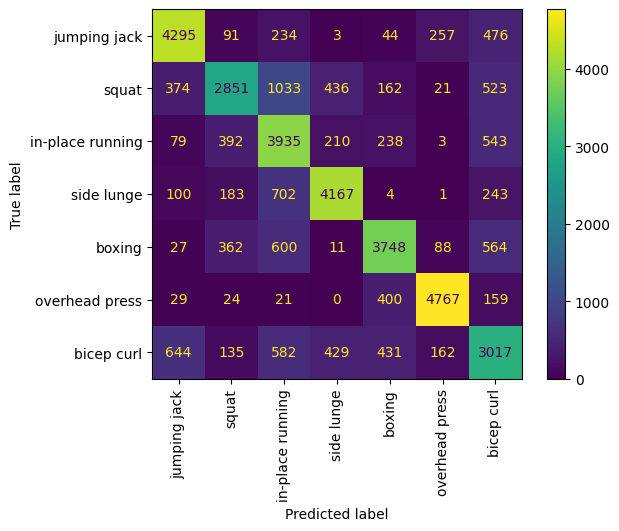

In [38]:
labels = [
    'jumping jack',
    'squat',
    'in-place running',
    'side lunge',
    'boxing',
    'overhead press',
    'bicep curl'
]


disp = ConfusionMatrixDisplay.from_estimator(
    clf_svm,X_test,y_test,display_labels=labels, xticks_rotation='vertical')

plt.show()

In-place running and squat are the actions most confused, we think that is because those movements look alike because the legs are in a 90 degrees position. 
The overhead press is the distinctively different from the others because it is the only one with the arm straight above the head.

### Training the classifier using Logistic Regression

In [12]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression())

param_grid = {
    'logisticregression__max_iter': [500, 1000, 1500],
    'logisticregression__C': [0.01, 0.1, 1, 10, 100]
}

# max_iter sets the maximum number of iterations 
# taken for the solvers to converge

# C controls the regularization strength. 
# smaller values specifiy stronger regularization.

clf_lr = GridSearchCV(pipeline, param_grid, cv=5)

clf_lr.fit(X,y)

# Best parameters and best score
print("Best Parameters:", clf_lr.best_params_)
print("Best Cross-Validation Score:", clf_lr.best_score_)

c:\Users\adeli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\adeli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Best Parameters: {'logisticregression__C': 100, 'logisticregression__max_iter': 500}
Best Cross-Validation Score: 0.6956038647342995


c:\Users\adeli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
# predict the labels for the test data
clf_lr = make_pipeline(StandardScaler(), LogisticRegression(C=100,max_iter=500))
clf_lr.fit(X,y)

/home/xdsoete/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=100, max_iter=500))])

In [40]:
y_pred_lr = clf_lr.predict(X)

print("accuracy:", accuracy_score(y, y_pred_lr))
print("precision:", precision_score(y,y_pred_lr, average=None))
print("recall:", recall_score(y, y_pred_lr, average=None))

accuracy: 0.8032298136645962
precision: [0.8328853  0.75134865 0.77216466 0.83530331 0.8127734  0.91166012
 0.70783732]
recall: [0.80826087 0.652657   0.81371981 0.82618357 0.80782609 0.94125604
 0.77270531]


### Training the classifier using RandomForest

In [15]:
pipeline = make_pipeline(RandomForestClassifier(random_state=0))

param_grid = {
    'randomforestclassifier__n_estimators': [50, 100],
    'randomforestclassifier__max_depth': [10, None]
}

# n_estimators controls the number of trees in the forest,
# more trees improve performance, but also increase computation time

# max_depth is used for the maximum depth of each tree.
# smaller depth can help avoiding overfitting for small datasets.

clf_rf = GridSearchCV(pipeline, param_grid, cv=5)

clf_rf.fit(X,y)

# Best parameters and best score
print("Best Parameters:", clf_rf.best_params_)
print("Best Cross-Validation Score:", clf_rf.best_score_)

Best Parameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 100}
Best Cross-Validation Score: 0.7071221532091096


Decision trees are unaffected by the range of values so Random forests are insensitive to scaling or standardization, so it is useless to scale or standardize the data.

In [45]:
clf_rf = RandomForestClassifier(max_depth=10, n_estimators=100)

clf_rf.fit(X,y)

RandomForestClassifier(max_depth=10)

In [46]:
y_pred_rf = clf_rf.predict(X)

print("accuracy:", accuracy_score(y, y_pred_rf))
print("precision:", precision_score(y,y_pred_rf, average=None))
print("recall:", recall_score(y, y_pred_rf, average=None))

accuracy: 0.8828916494133885
precision: [0.99784017 0.96518057 0.76355573 0.95852187 0.92206907 0.97358363
 0.72124318]
recall: [0.78115942 0.79275362 0.91497585 0.85961353 0.91454106 0.9721256
 0.94507246]


In [47]:
y_pred_test_rf = clf_rf.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred_test_rf))
print("precision:", precision_score(y_test,y_pred_test_rf, average=None))
print("recall:", recall_score(y_test, y_pred_test_rf, average=None))

accuracy: 0.6851851851851852
precision: [0.74495446 0.81894671 0.61448532 0.71043889 0.7204611  0.93831823
 0.43065122]
recall: [0.77240741 0.48666667 0.79814815 0.75240741 0.78703704 0.69018519
 0.50944444]


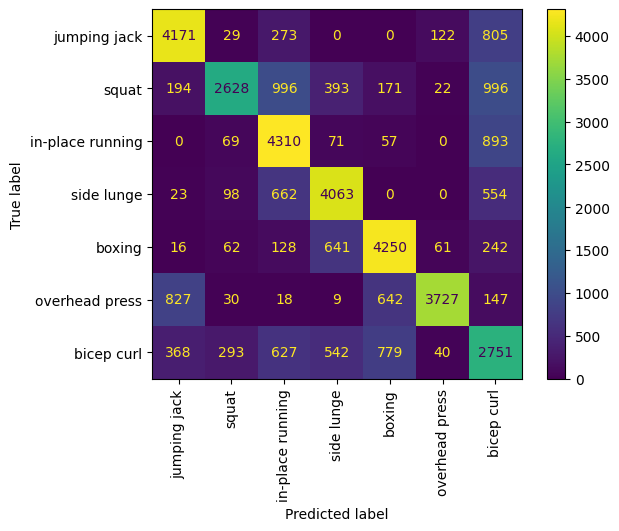

In [48]:
disp = ConfusionMatrixDisplay.from_estimator(
    clf_rf,X_test,y_test,display_labels=labels, xticks_rotation='vertical')

plt.show()

### Training the classifier using Gaussian Naive Bayes

In [18]:
pipeline = make_pipeline(GaussianNB())

param_grid = {
    'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]  # Smoothing parameter
}

# adds a small value to the variance to prevent zero variance, 
# this helps to stabilize the model when data contains very small variances


gnb = GridSearchCV(pipeline, param_grid, cv=5)

gnb.fit(X,y)

# Best parameters and best score
print("Best Parameters:", gnb.best_params_)
print("Best Cross-Validation Score:", gnb.best_score_)

Best Parameters: {'gaussiannb__var_smoothing': 1e-09}
Best Cross-Validation Score: 0.50175983436853


In [21]:
# predict the labels for the test data
gnb = GaussianNB(var_smoothing=1e-9)

gnb.fit(X,y)

GaussianNB()

In [ ]:
y_pred = gnb.predict(X)

print("accuracy:", accuracy_score(y, y_pred))
print("precision:", precision_score(y,y_pred, average=None))
print("recall:", recall_score(y, y_pred, average=None))

## Predictive model candidate

We chooose the random forest classification because it has the highest accuracy, precision and recall scores of the chosen models. Using cross validation on this model using max_depth=None, our classifier was overfit resulting in a perfect score of 100% on accuracy, precision and recall on the train data. On the test data, the score was horribly worse. This was caused by the fact that max_depth=None caused the tree to grow till every data point was in its own leaf node, causing the model to perfectly predict on data it had seen before, but worse on data it hadn't seen yet.

We decided ourselves to lower the max_depth value to 10, to prevent this from happening.

SVM and linear regression are used to model linear relations. Random forest classification can model more complex relations and is not limited to linearity.

Gaussian Naive Bayes assumes the data is independant and normally distributed, which isn't the case for our data. When you move your elbow your wrist will move as well, thus the data points are not independant.

### Feature importance

In [86]:
df_2 = df.drop(df.columns[[3,4,5,42,43,44,45,46,47,48,49,50,51,52,53]],axis=1)
df_2

,0,1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,318.662460,128.835426,0.988745,268.949184,171.237928,0.883163,197.303580,168.313617,0.980655,124.195821,153.692065,1.013843,365.451426,168.313617,0.908882,431.248410,168.313617,1.021971,492.658927,159.540686,0.972247,280.646426,320.377761,0.825018,252.865477,424.190781,0.834374,236.781770,479.752680,0.728263,340.594788,323.302071,0.846822,363.989271,427.115092,0.846408,371.300047,479.752680,0.722725
1,321.717529,122.370902,0.940747,267.336910,163.156368,0.857000,199.361136,151.071785,0.928518,129.874790,125.392048,0.986224,368.545285,163.156368,0.879295,435.010486,154.092931,0.956867,489.391105,137.476630,0.912547,282.442638,320.255938,0.839197,246.188892,425.996033,0.844457,226.551446,480.376654,0.741127,342.865548,321.766511,0.838805,370.055857,424.485461,0.836584,383.651012,478.866081,0.702781
2,319.964469,121.905897,0.965959,269.848226,159.872748,0.840856,203.026567,137.092638,0.915790,139.242257,108.237831,0.942661,368.562039,159.872748,0.859406,433.865024,143.167334,0.915333,485.499942,117.349875,0.875451,281.997618,317.814845,0.823065,244.030767,425.640701,0.829147,216.694634,477.275617,0.716120,342.744580,319.333519,0.827314,374.636735,425.640701,0.816173,392.860824,477.275617,0.670228
3,324.417555,121.279817,0.921174,270.260036,155.579579,0.885880,208.881514,128.500820,0.918937,151.113493,90.590556,0.943666,365.938320,159.190081,0.912657,425.511591,139.332324,0.914573,483.279612,105.032561,0.864403,282.896791,318.052137,0.910160,241.376026,422.756675,0.868748,208.881514,480.524695,0.789206,342.470062,318.052137,0.914653,376.769824,422.756675,0.852700,402.043333,482.329946,0.725556
4,323.386245,123.784732,0.879802,273.821306,162.157587,0.836961,213.064284,125.383601,0.902214,158.702737,79.016401,0.949641,368.154577,160.558718,0.832952,425.713861,133.377946,0.863717,480.075408,93.406222,0.843241,281.815651,322.044484,0.834399,238.646188,432.366443,0.848860,203.471070,480.332512,0.682816,342.572673,322.044484,0.838622,379.346660,429.168705,0.815989,408.126302,478.733643,0.580895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144895,286.852182,178.051128,0.906847,233.102986,239.944139,0.768356,223.330405,319.753547,0.786147,207.042769,384.904085,0.816813,334.086324,240.758521,0.772113,343.858905,318.124784,0.736277,354.445868,381.646558,0.755926,252.648148,382.460940,0.609252,259.977584,476.929219,0.668454,266.492638,516.019542,0.264264,314.541162,382.460940,0.619421,307.211726,474.486074,0.694861,305.582962,451.683386,0.269926
144896,286.713130,175.934557,0.942934,233.973895,237.319566,0.799875,218.411498,315.996127,0.817018,186.422127,374.787403,0.813681,334.264898,238.184144,0.810251,348.098140,315.131549,0.797559,372.306313,372.193671,0.816666,252.130025,376.516558,0.661556,260.775801,475.942981,0.708207,263.369534,520.036439,0.296928,316.108768,377.381136,0.680741,307.462992,474.213826,0.719044,304.869260,452.599387,0.259430
144897,286.211247,167.680168,0.932690,236.655318,226.766083,0.854552,205.206363,298.240981,0.863839,164.227422,350.655906,0.848389,331.955182,228.672081,0.869739,357.686145,300.146978,0.892728,396.759089,353.514902,0.892971,251.903296,367.809882,0.755119,262.386281,473.592731,0.741435,263.339280,524.101658,0.353876,318.613201,367.809882,0.771030,310.036213,471.686733,0.770083,308.130216,524.101658,0.320531
144898,289.311251,157.972077,0.910177,236.564997,215.207372,0.846006,191.674568,281.420753,0.877210,136.683792,324.066659,0.851187,333.079419,217.451894,0.868301,371.236284,282.543014,0.872329,422.860278,327.433441,0.892730,256.765690,363.345783,0.689596,262.376993,469.960549,0.783144,259.010211,468.838288,0.464650,319.612291,363.345783,0.723373,312.878726,469.960549,0.791231,310.634205,468.838288,0.438892


We removed the neck, ears and eyes, because we think these features aren't that important for our classifier. While performing the actions no important movement is done with the ears, eyes and neck. We kept the other features like the limbs, because these characterise important movements like stretching or bending an arm. We kept the nose to have knowledge of where the head is positioned.

In [87]:
X_2 = df_2.to_numpy()

In [105]:
pipeline = make_pipeline(RandomForestClassifier(random_state=0))

param_grid = {
    'randomforestclassifier__n_estimators': [50, 100],
    'randomforestclassifier__max_depth': [10, 20]
}

# n_estimators controls the number of trees in the forest,
# more trees improve performance, but also increase computation time

# max_depth is used for the maximum depth of each tree.
# smaller depth can help avoiding overfitting for small datasets.

clf_2_rf = GridSearchCV(pipeline, param_grid, cv=5)

clf_2_rf.fit(X,y)

# Best parameters and best score
print("Best Parameters:", clf_2_rf.best_params_)
print("Best Cross-Validation Score:", clf_2_rf.best_score_)

Best Parameters: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 100}
Best Cross-Validation Score: 0.7313664596273293


In [108]:
clf_2_rf = RandomForestClassifier(max_depth=10, n_estimators=100)

clf_2_rf.fit(X_2,y)

RandomForestClassifier(max_depth=15)

In [103]:
y_pred_rf = clf_2_rf.predict(X_2)

print("accuracy:", accuracy_score(y, y_pred_rf))
print("precision:", precision_score(y,y_pred_rf, average=None))
print("recall:", recall_score(y, y_pred_rf, average=None))

accuracy: 0.8926017943409248
precision: [0.99374894 0.96666097 0.71911388 0.97255811 0.93267896 0.97331725
 0.79435519]
recall: [0.85246377 0.81942029 0.94874396 0.85091787 0.90888889 0.97449275
 0.89328502]


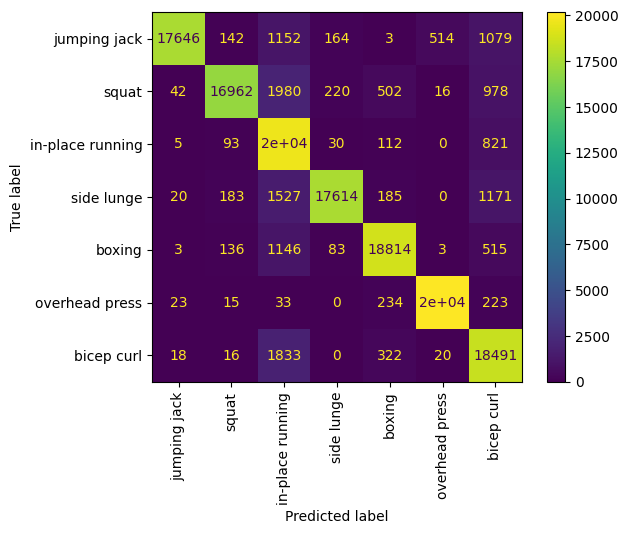

In [104]:
disp = ConfusionMatrixDisplay.from_estimator(
    clf_2_rf,X_2,y,display_labels=labels, xticks_rotation='vertical')

plt.show()